In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import datajoint as dj
from photonics.space import Space

In [2]:
schema = dj.schema('photonics')

Connecting dimitri@localhost:3306


In [3]:
@schema
class DSim(dj.Lookup):
    definition = """
    # Detector Field Specification
    dsim : int
    --- 
    dsim_description  : varchar(1024)  
    detector_type='one-sided' : varchar(30)   # choice in simulation
    detector_width=10.00: decimal(5,2)   # (um) along x-axis
    detector_height=10.00:  decimal(5,2)  # (um) along y-axis
    anisotropy = 0.88 : float  # factor in the Henyey-Greenstein formula
    absorption_length = 14000 : float # (um)  average travel path before a absoprtion event 
    scatter_length=100 : float # (um) average travel path before a scatter event
    volume_dimx = 1000 : int unsigned # (voxels)
    volume_dimy = 1000 : int unsigned # (voxels)
    volume_dimz = 1000 : int unsigned # (voxels)
    pitch = 2.2 : float  # (um)  spatial sampling period of the model volume
    """
   
    contents = [
        dict(dsim=0, detector_type='one-sided', detector_height=50, 
             dsim_description='100% Efficient Lambertian 10x50 rect'),
        dict(dsim=1, detector_type='one-sided', detector_height=10, 
             dsim_description='100% Efficient Lambertian 10x10 rect'),
        dict(dsim=2, detector_type='narrowed', detector_height=10, 
             dsim_description="Narrow selective as 4th power of cosine, 10x10 rect")]

In [4]:
@schema
class DField(dj.Computed):
    definition = """
    # Detector Field Reference Volume
    -> DSim
    ---
    volume : blob@photonics   # probability of a photon emitted at given point getting picked up by the given detector
    max_value : float   # should be < 1.0
    total_photons : int unsigned
    """
    
    def make(self, key):
        spec = (DSim & key).fetch1()
        
        kwargs = {k: spec[k] for k in spec if k in {
            'pitch', 'anisotropy', 'scatter_length', 'absorption_length', 'detector_type'}}
        
        kwargs.update(
            dims=tuple(spec[k] for k in ('volume_dimx', 'volume_dimy', 'volume_dimz')),
            emitter_spread='spherical',
            emitter_size=(float(spec['detector_width']), float(spec['detector_height']), 0))
        
        space = Space(**kwargs)
        space.run(hops=500_000)
        volume = space.volume * space.emitter_area
        self.insert1(dict(
            key, 
            volume=np.float32(volume), 
            max_value=volume.max(),
            total_photons=space.total_count))        

    
    def plot(self, figsize=(8, 8), axis=None, gamma=0.7, cmap='gray_r', title=''):
        from matplotlib_scalebar.scalebar import ScaleBar
        info = (self * DSim).fetch1()
        if axis is None:
            _, axis = plt.subplots(1, 1, figsize=(8, 8))
        axis.imshow((info['volume'].sum(axis=0))**gamma, cmap=cmap)
        axis.axis(False)
        scale_bar = ScaleBar(info['pitch']*1e-6)
        axis.add_artist(scale_bar)
        title = f"{title}\n{info['total_photons']/1e6:0.2f} million simulated photons"
        axis.set_title(title)
        

In [5]:
DField.populate()

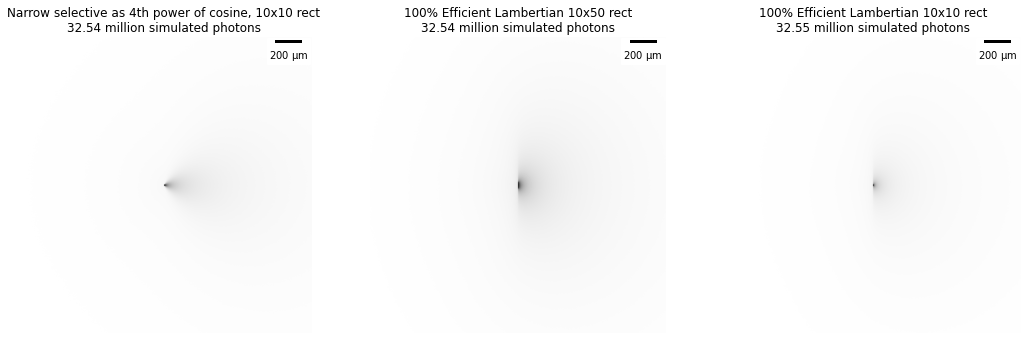

In [15]:
keys = DField.fetch('KEY')
fig, ax = plt.subplots(1, len(keys), figsize=(6*len(keys), 6))
for a, key in zip(ax.flatten(), keys):
    (DField & key).plot(axis=a, title=(DSim & key).fetch1('dsim_description'))
fig.savefig('detector-fields.png')

In [7]:
DField()

dsim,volume probability of a photon emitted at given point getting picked up by the given detector,max_value should be < 1.0,total_photons
0,=BLOB=,0.745442,32541289
1,=BLOB=,0.553713,32545599
2,=BLOB=,0.114449,32538238


In [8]:
# !open detector-fields.pdf

In [9]:
@schema
class ESim(dj.Lookup):
    definition = """
    # Emission Field Specification
    esim : int
    --- 
    esim_description : varchar(1024) 
    beam_compression : float  
    y_steer : float   # the steer angle in the plane of the shank
    emitter_width=10.00: decimal(5,2)   # (um) along x-axis
    emitter_height=10.00:  decimal(5,2)  # (um) along y-axis
    anisotropy = 0.88 : float  # factor in the Henyey-Greenstein formula
    absorption_length = 14000 : float # (um)  average travel path before a absoprtion event    
    scatter_length=100 : float # (um) average travel path before a scatter event
    volume_dimx = 1000 : int unsigned # (voxels)
    volume_dimy = 1000 : int unsigned # (voxels)
    volume_dimz = 1000 : int unsigned # (voxels)
    pitch = 2.2 : float  # (um)  spatial sampling period of the model volume
    """
    
    contents = [
        dict(esim=0, esim_description="Lambertian 10 x 10", 
             beam_compression=1.0, y_steer=0.0),
        dict(esim=10, esim_description="Narrowed to pi/4, steered -24/64*pi",
             beam_compression=1/4, y_steer=-24/64*np.pi),
        dict(esim=11, esim_description="Narrowed to \pi/4, steered -18/64*pi",
             beam_compression=1/4, y_steer=-18/64*np.pi),
        dict(esim=12, esim_description="Narrowed to \pi/4, steered -12/64*pi",
             beam_compression=1/4, y_steer=-12/64*np.pi),
        dict(esim=13, esim_description="Narrowed to \pi/4, steered -6/64*pi",
             beam_compression=1/4, y_steer= -6/64*np.pi),
        dict(esim=14, esim_description="Narrowed to \pi/4, steered 0",
             beam_compression=1/4, y_steer= 0*np.pi),
        dict(esim=15, esim_description="Narrowed to \pi/4, steered +6/64*pi",
             beam_compression=1/4, y_steer=+6/64*np.pi),
        dict(esim=16, esim_description="Narrowed to \pi/4, steered +12/64*pi",
             beam_compression=1/4, y_steer=+12/64*np.pi),
        dict(esim=17, esim_description="Narrowed to \pi/4, steered +18/64*pi",
             beam_compression=1/4, y_steer=+18/64*np.pi),
        dict(esim=18, esim_description="Narrowed to \pi/4, steered +24/64*pi",
             beam_compression=1/4, y_steer=+24/64*np.pi),
    ]

In [10]:
ESim()

esim,esim_description,beam_compression,y_steer the steer angle in the plane of the shank,emitter_width (um) along x-axis,emitter_height (um) along y-axis,anisotropy factor in the Henyey-Greenstein formula,absorption_length (um) average travel path before a absoprtion event,scatter_length (um) average travel path before a scatter event,volume_dimx (voxels),volume_dimy (voxels),volume_dimz (voxels),pitch (um) spatial sampling period of the model volume
0,Lambertian 10 x 10,1.0,0.0,10.00,10.00,0.88,14000.0,100.0,1000,1000,1000,2.2
10,"Narrowed to pi/4, steered -24/64*pi",0.25,-1.1781,10.00,10.00,0.88,14000.0,100.0,1000,1000,1000,2.2
11,"Narrowed to \pi/4, steered -18/64*pi",0.25,-0.883573,10.00,10.00,0.88,14000.0,100.0,1000,1000,1000,2.2
12,"Narrowed to \pi/4, steered -12/64*pi",0.25,-0.589049,10.00,10.00,0.88,14000.0,100.0,1000,1000,1000,2.2
13,"Narrowed to \pi/4, steered -6/64*pi",0.25,-0.294524,10.00,10.00,0.88,14000.0,100.0,1000,1000,1000,2.2
14,"Narrowed to \pi/4, steered 0",0.25,0.0,10.00,10.00,0.88,14000.0,100.0,1000,1000,1000,2.2
15,"Narrowed to \pi/4, steered +6/64*pi",0.25,0.294524,10.00,10.00,0.88,14000.0,100.0,1000,1000,1000,2.2
16,"Narrowed to \pi/4, steered +12/64*pi",0.25,0.589049,10.00,10.00,0.88,14000.0,100.0,1000,1000,1000,2.2
17,"Narrowed to \pi/4, steered +18/64*pi",0.25,0.883573,10.00,10.00,0.88,14000.0,100.0,1000,1000,1000,2.2
18,"Narrowed to \pi/4, steered +24/64*pi",0.25,1.1781,10.00,10.00,0.88,14000.0,100.0,1000,1000,1000,2.2


In [11]:
@schema
class EField(dj.Computed):
    definition = """
    # Emitter Field Reference Volume
    -> ESim
    ---
    volume : blob@photonics   # probability of a photon emitted at given point getting picked up by the given detector
    total_photons : int unsigned
    """
    
    def make(self, key):
        spec = (ESim & key).fetch1()
        
        kwargs = {k: spec[k] for k in spec if k in {
            'pitch', 'anisotropy', 'scatter_length',
            'y_steer', 'beam_compression',
            'absorption_length'}}
        
        kwargs.update(
            dims=tuple(spec[k] for k in ('volume_dimx', 'volume_dimy', 'volume_dimz')),
            emitter_size=(float(spec['emitter_width']), float(spec['emitter_height']), 0))
        
        space = Space(**kwargs)
        space.run(hops=500_000)
        self.insert1(dict(
            key, 
            volume=np.float32(space.volume), 
            total_photons=space.total_count))        

    
    def plot(self, figsize=(8, 8), axis=None, gamma=0.7, cmap='magma', title=''):
        from matplotlib_scalebar.scalebar import ScaleBar
        info = (self * ESim).fetch1()
        if axis is None:
            _, axis = plt.subplots(1, 1, figsize=(8, 8))
        axis.imshow((info['volume'].sum(axis=0))**gamma, cmap=cmap)
        axis.axis(False)
        scale_bar = ScaleBar(info['pitch']*1e-6)
        axis.add_artist(scale_bar)
        title = f"{title}\n{info['total_photons']/1e6:0.2f} million simulated photons"
        axis.set_title(title)
        

In [12]:
EField.populate(reserve_jobs=True)

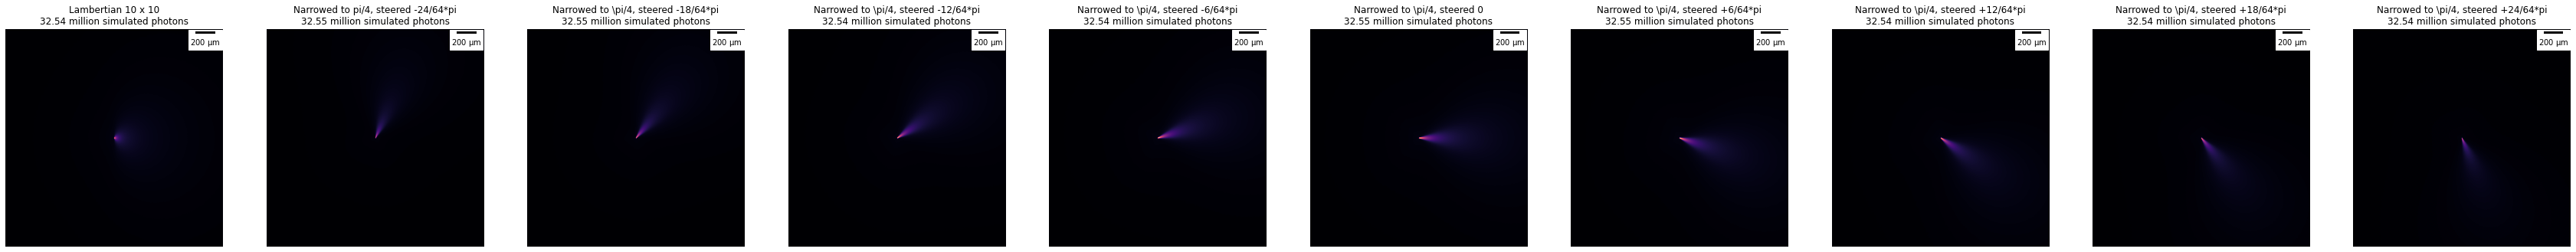

In [13]:
keys = EField.fetch('KEY', order_by="KEY")
fig, ax = plt.subplots(1, len(keys), figsize=(6*len(keys), 6))
for a, key in zip(ax.flatten(), keys):
    (EField & key).plot(axis=a, title=(ESim & key).fetch1('esim_description'))
fig.savefig('emitter-fields.png')

In [16]:
EField.fetc

{'dsim': 1}

In [14]:
!open emitter-fields.pdf

The file /Users/dimitri/dev/photonics/simulight/notebooks/emitter-fields.pdf does not exist.


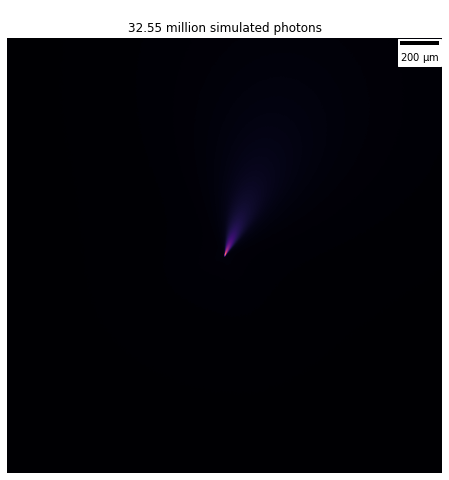

In [19]:
(EField & 'esim=10').plot()